In [1]:
import torch
import pandas as pd
from pathlib import Path
from torch.profiler import profile, record_function, ProfilerActivity
import math

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib.style.use("fivethirtyeight")
# matplotlib.style.use("seaborn-v0_8-talk")
matplotlib.rcParams["font.family"] = "monospace"
matplotlib.rcParams["figure.dpi"] = 200
plt.rcParams["savefig.facecolor"] = "white"

torch.random.manual_seed(0)

print(torch.__version__)


2.0.0.dev20230213+cu117


In [2]:
DEVICE = "cuda"
PROFILER_OUTDIR = Path("profiler_output")
PATCH_SIZE = 16

densify = lambda x: x.to_dense() if x.is_sparse else x
cooify = lambda x : x.to_sparse_coo()
cscify = lambda x : x.to_sparse_csc()
csrify = lambda x : x.to_sparse_csr()
bsrify = lambda x : x.to_sparse_bsr((16, 16))

MATRIX_TYPES = [
    ("dense", densify),
    ("coo", cooify),
    # ("csc", cscify),
    ("csr", csrify),
    ("bsr", bsrify),
]


In [3]:
SIZES = [512, 1024, 2048, 4096, 8192, 16384]
PERCENTAGES_NONZERO = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]


def run_benchmark(profiling=False):
    results = []
    for size in SIZES:
        b = torch.rand((size, 1), device=DEVICE, dtype=torch.float32)
        for percentage_nonzero in PERCENTAGES_NONZERO:
            # Define the number of patches to set to a non-zero value
            num_patches = math.ceil(size**2 * percentage_nonzero / PATCH_SIZE**2)
            # Create a tensor of zeros with the specified shape
            A_dense = torch.zeros((size, size), device=DEVICE, dtype=torch.float32)
            # Set a random set of patches to random values
            for i in range(num_patches):
                # Generate random row and column indices for the top-left corner of the patch
                row_idx = torch.randint(size - PATCH_SIZE + 1, (1,))
                col_idx = torch.randint(size - PATCH_SIZE + 1, (1,))
                # Generate a random patch with values between min_value and max_value
                patch = torch.rand((PATCH_SIZE, PATCH_SIZE))
                # Set the patch in the dense matrix
                A_dense[row_idx : row_idx + PATCH_SIZE, col_idx : col_idx + PATCH_SIZE] = patch

            archieved_percentage = A_dense.count_nonzero() / (size * size)
            print(
                f"Running {size}x{size} with {percentage_nonzero * 100}% non-zero (achieved {archieved_percentage * 100}%)"
            )

            for name, matrix_fun in MATRIX_TYPES:
                matrix = matrix_fun(A_dense)
                with profile(
                    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
                    with_stack=profiling,
                    record_shapes=profiling,
                ) as prof:
                    _ = torch.matmul(matrix, b)
                result = {
                    "size": size,
                    "percentage_nonzero": percentage_nonzero,
                    "name": name,
                    "cuda_micros": prof.key_averages().total_average().self_cuda_time_total,
                    "cpu_micros": prof.key_averages().total_average().self_cpu_time_total,
                }
                results.append(result)
                if profiling:
                    prof.export_chrome_trace(
                        str(
                            PROFILER_OUTDIR
                            / f"torch_sparse_{size}_{percentage_nonzero}_{name}.json"
                        )
                    )
                    prof.export_stacks(
                        str(
                            PROFILER_OUTDIR
                            / f"torch_sparse_stacks_{size}_{percentage_nonzero}_{name}.txt"
                        ),
                        "self_cuda_time_total",
                    )
    return results


results = run_benchmark(profiling=False)
df = pd.DataFrame(results)
df.to_csv(PROFILER_OUTDIR / "torch_sparse_results.csv", index=False)


Running 512x512 with 0.01% non-zero (achieved 0.09765625%)


STAGE:2023-02-17 19:44:58 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
/tmp/ipykernel_149165/4244064320.py:8: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  csrify = lambda x : x.to_sparse_csr()
STAGE:2023-02-17 19:44:59 149

Running 512x512 with 0.1% non-zero (achieved 0.1953125%)
Running 512x512 with 1.0% non-zero (achieved 1.07421875%)
Running 512x512 with 5.0% non-zero (achieved 4.8206329345703125%)
Running 512x512 with 10.0% non-zero (achieved 9.579086303710938%)
Running 512x512 with 20.0% non-zero (achieved 18.151473999023438%)
Running 512x512 with 30.0% non-zero (achieved 26.360702514648438%)
Running 1024x1024 with 0.01% non-zero (achieved 0.0244140625%)
Running 1024x1024 with 0.1% non-zero (achieved 0.110626220703125%)
Running 1024x1024 with 1.0% non-zero (achieved 1.0009765625%)
Running 1024x1024 with 5.0% non-zero (achieved 4.892921447753906%)
Running 1024x1024 with 10.0% non-zero (achieved 9.50927734375%)


STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerCo

Running 1024x1024 with 20.0% non-zero (achieved 17.926025390625%)
Running 1024x1024 with 30.0% non-zero (achieved 26.110458374023438%)
Running 2048x2048 with 0.01% non-zero (achieved 0.01220703125%)
Running 2048x2048 with 0.1% non-zero (achieved 0.103759765625%)


STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerCo

Running 2048x2048 with 1.0% non-zero (achieved 0.9963750839233398%)
Running 2048x2048 with 5.0% non-zero (achieved 4.873418807983398%)
Running 2048x2048 with 10.0% non-zero (achieved 9.573078155517578%)
Running 2048x2048 with 20.0% non-zero (achieved 18.041492462158203%)


STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:44:59 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerCo

Running 2048x2048 with 30.0% non-zero (achieved 25.76940155029297%)
Running 4096x4096 with 0.01% non-zero (achieved 0.01068115234375%)


STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:00 149165:149165 ActivityProfilerCo

Running 4096x4096 with 0.1% non-zero (achieved 0.1007080078125%)


STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerCo

Running 4096x4096 with 1.0% non-zero (achieved 0.9958088397979736%)


STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerCo

Running 4096x4096 with 5.0% non-zero (achieved 4.878717422485352%)


STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:01 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


Running 4096x4096 with 10.0% non-zero (achieved 9.528350830078125%)


STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


Running 4096x4096 with 20.0% non-zero (achieved 18.134641647338867%)


STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:02 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:03 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:03 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:03 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:03 149165:149165 ActivityProfilerCo

Running 4096x4096 with 30.0% non-zero (achieved 25.927698135375977%)


STAGE:2023-02-17 19:45:03 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:03 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:03 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:03 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:03 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:03 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:04 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:04 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:04 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:04 149165:149165 ActivityProfilerCo

Running 8192x8192 with 0.01% non-zero (achieved 0.0102996826171875%)


STAGE:2023-02-17 19:45:05 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:05 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:05 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:05 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:05 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:05 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:05 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:05 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:05 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


Running 8192x8192 with 0.1% non-zero (achieved 0.1003265380859375%)


STAGE:2023-02-17 19:45:05 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:05 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:05 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:06 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:06 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:06 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:06 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:06 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:06 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


Running 8192x8192 with 1.0% non-zero (achieved 0.9957700967788696%)


STAGE:2023-02-17 19:45:06 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:06 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:06 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:06 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:06 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:06 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:07 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:07 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:07 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:07 149165:149165 ActivityProfilerCo

Running 8192x8192 with 5.0% non-zero (achieved 4.878297328948975%)


STAGE:2023-02-17 19:45:08 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:08 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:08 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:08 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:08 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:08 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:09 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:09 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:09 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:09 149165:149165 ActivityProfilerCo

Running 8192x8192 with 10.0% non-zero (achieved 9.534184455871582%)


STAGE:2023-02-17 19:45:10 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:10 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:10 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:10 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:10 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:10 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:11 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:11 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:11 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:11 149165:149165 ActivityProfilerCo

Running 8192x8192 with 20.0% non-zero (achieved 18.11270523071289%)


STAGE:2023-02-17 19:45:12 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:12 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:12 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:12 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:12 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:12 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:14 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:14 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:14 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:14 149165:149165 ActivityProfilerCo

Running 8192x8192 with 30.0% non-zero (achieved 25.89494514465332%)


STAGE:2023-02-17 19:45:15 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:15 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:15 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:16 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:16 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:16 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:17 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:17 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:17 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:17 149165:149165 ActivityProfilerCo

Running 16384x16384 with 0.01% non-zero (achieved 0.010013580322265625%)


STAGE:2023-02-17 19:45:17 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:17 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:17 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:17 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:17 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:17 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:21 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:21 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:21 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:21 149165:149165 ActivityProfilerCo

Running 16384x16384 with 0.1% non-zero (achieved 0.09999684989452362%)


STAGE:2023-02-17 19:45:22 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:22 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:22 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:25 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:25 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:25 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:26 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:26 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:26 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


Running 16384x16384 with 1.0% non-zero (achieved 0.9947720766067505%)


STAGE:2023-02-17 19:45:26 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:26 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:26 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:26 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:26 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:26 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:30 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:30 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:30 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:30 149165:149165 ActivityProfilerCo

Running 16384x16384 with 5.0% non-zero (achieved 4.879586219787598%)


STAGE:2023-02-17 19:45:31 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:31 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:31 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:32 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:32 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:32 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:36 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:36 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:36 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:36 149165:149165 ActivityProfilerCo

Running 16384x16384 with 10.0% non-zero (achieved 9.520556449890137%)


STAGE:2023-02-17 19:45:38 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:38 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:38 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:39 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:39 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:39 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:43 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:43 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:43 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:43 149165:149165 ActivityProfilerCo

Running 16384x16384 with 20.0% non-zero (achieved 18.12505531311035%)


STAGE:2023-02-17 19:45:48 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:48 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:48 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:48 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:49 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:49 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:53 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:45:53 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:45:53 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:45:53 149165:149165 ActivityProfilerCo

Running 16384x16384 with 30.0% non-zero (achieved 25.898637771606445%)


STAGE:2023-02-17 19:46:00 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:46:00 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:46:00 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:46:00 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:46:01 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:46:01 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:46:05 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:46:06 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:46:06 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:46:06 149165:149165 ActivityProfilerCo

In [4]:
SIZES = [8192]
PERCENTAGES_NONZERO = [0.05]
_ = run_benchmark(profiling=True)

Running 8192x8192 with 5.0% non-zero (achieved 4.876023292541504%)


STAGE:2023-02-17 19:46:07 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:46:07 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:46:07 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:46:07 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:46:07 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:46:07 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:46:08 149165:149165 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:46:08 149165:149165 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:46:08 149165:149165 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:46:08 149165:149165 ActivityProfilerCo

In [7]:
df = pd.read_csv(PROFILER_OUTDIR / "torch_sparse_results.csv")
df["percentage_nonzero"] = (df["percentage_nonzero"] * 100)
df["cuda_millis"] = df["cuda_micros"] / 1000
df["cpu_millis"] = df["cpu_micros"] / 1000
df

,size,percentage_nonzero,name,cuda_micros,cpu_micros,cuda_millis,cpu_millis
0,512,0.01,dense,0,309437,0.0,309.437
1,512,0.01,coo,0,251,0.0,0.251
2,512,0.01,csr,0,531,0.0,0.531
3,512,0.01,bsr,0,102,0.0,0.102
4,512,0.10,dense,0,62,0.0,0.062
...,...,...,...,...,...,...,...
163,16384,20.00,bsr,0,41998,0.0,41.998
164,16384,30.00,dense,0,17049,0.0,17.049
165,16384,30.00,coo,0,917995,0.0,917.995
166,16384,30.00,csr,0,59225,0.0,59.225


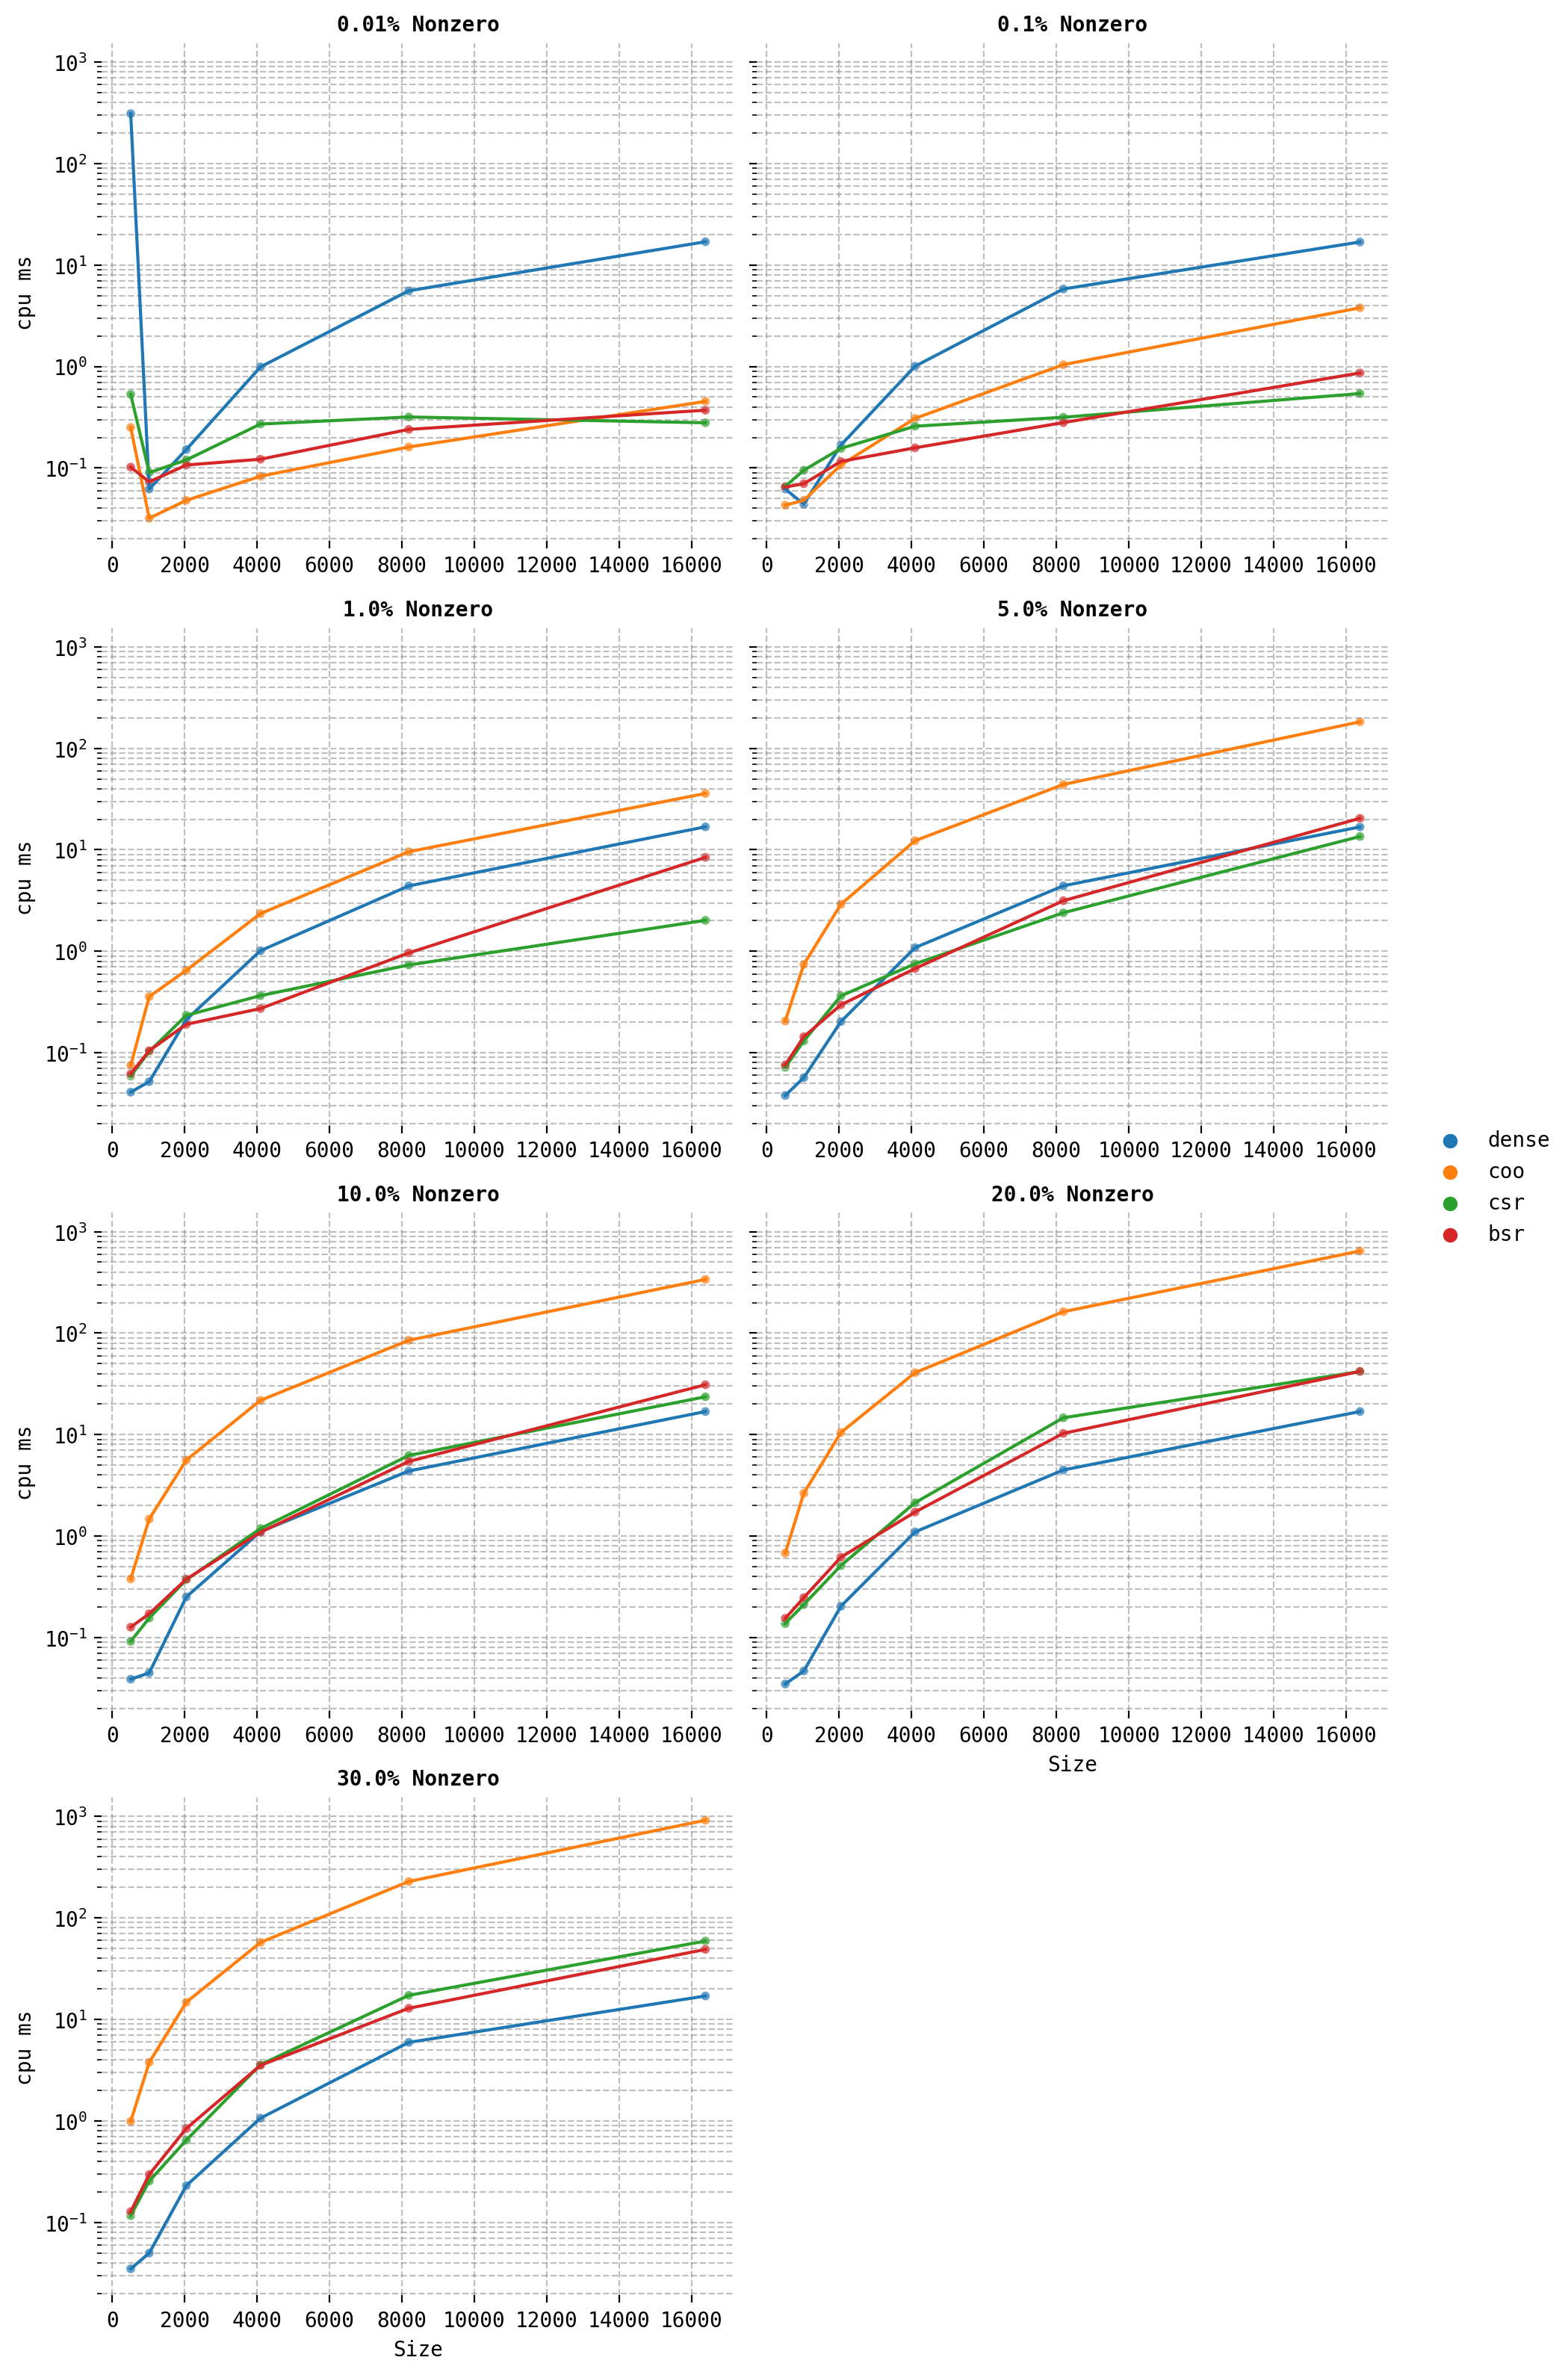

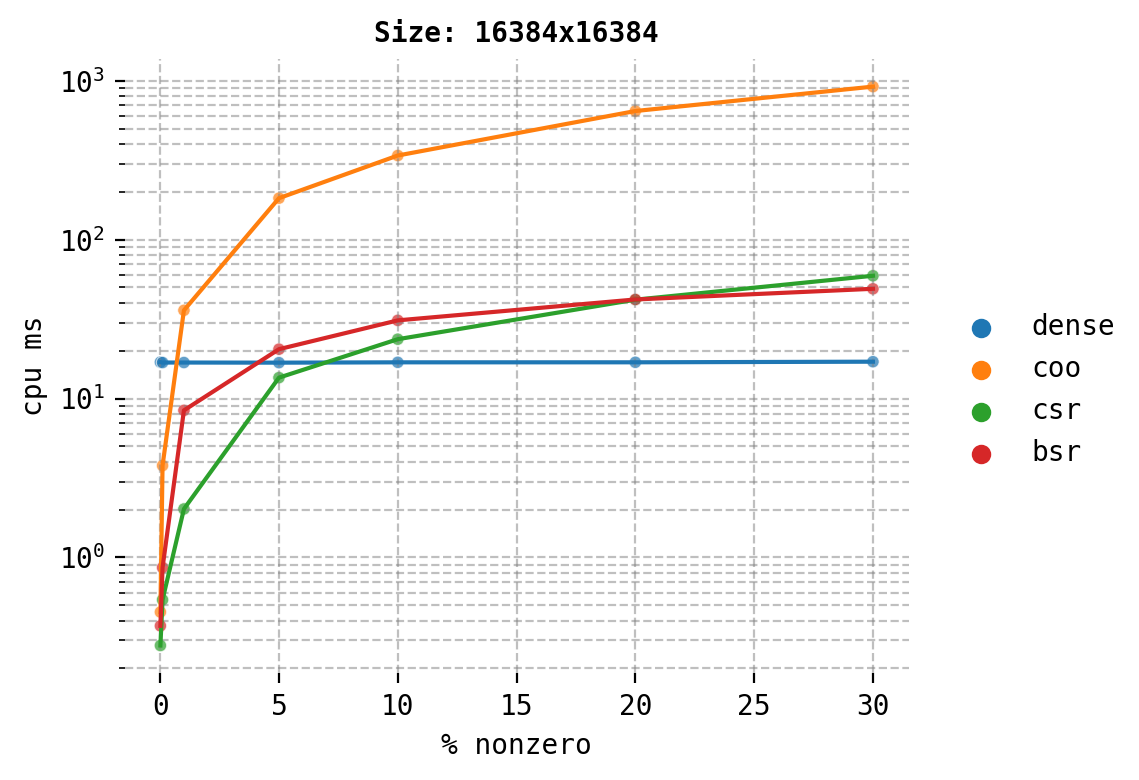

In [9]:
# Create the lineplots with log y-scale and dots
g = sns.FacetGrid(
    df, col="percentage_nonzero", height=4, aspect=1.2, col_wrap=2, sharey=True, sharex=False
)
g.map(sns.lineplot, "size", f"{DEVICE}_millis", "name")
g.map(sns.scatterplot, "size", f"{DEVICE}_millis", "name", color="black", alpha=0.7, s=20)
g.set(yscale="log")

# Set the titles and labels
g.set_titles(col_template="{col_name}% Nonzero", fontweight="bold")
g.set_axis_labels("Size", f"{DEVICE} ms")

# Add legend
g.add_legend()

# add grid
g.despine(left=True, bottom=True)
g.map(plt.grid, which="both", axis="both", ls="--", color="grey", alpha=0.5)

# Show the plot
plt.show()
# save the plot
g.savefig(f"torch_sparse_plot_{DEVICE}.png")

# largest size only
sub_df = df[df["size"] == df["size"].max()]
g = sns.FacetGrid(
    sub_df, col="size", height=4, aspect=1.2, sharey=True, sharex=False
)
g.map(sns.lineplot, "percentage_nonzero", f"{DEVICE}_millis", "name")
g.map(sns.scatterplot, "percentage_nonzero", f"{DEVICE}_millis", "name", color="black", alpha=0.7, s=20)
g.set(yscale="log")

# Set the titles and labels
g.set_titles(col_template="Size: {col_name}x{col_name}", fontweight="bold")
g.set_axis_labels("% nonzero", f"{DEVICE} ms")

# Add legend
g.add_legend()

# add grid
g.despine(left=True, bottom=True)
g.map(plt.grid, which="both", axis="both", ls="--", color="grey", alpha=0.5)

# Show the plot
plt.show()
g.savefig(f"torch_sparse_plot_largest_{DEVICE}.png")